In [8]:
# importing the packages we will be using for this project
import pandas as pd
# setting pandas display to avoid scientific notation in my dataframes
pd.options.display.float_format = '{:.2f}'.format
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from bs4 import BeautifulSoup
import json
import requests

import folium

import haversine as hs 

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import scipy.stats as stats

import pylab

%matplotlib inline

### Model With Price as Target, Quantile-Transformed Data

In [16]:
df = pd.read_csv('./data/all_features_quant_transformed.csv')
df.head()

,Unnamed: 0,price,sqft_living,lat,long,min_dist_park,closest_distance_to_top_school,closest_distance_to_great_coffee,closest_distance_to_scientology,log_school,...,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,interaction
0,0,-1.60,-1.08,47.51,-122.26,-0.31,-1.61,-0.93,-0.24,-1.34,...,0,0,0,1,0,0,0,0,0,0.38
1,1,0.49,0.94,47.72,-122.32,0.92,-0.50,0.71,-0.40,-0.38,...,0,0,0,1,0,0,0,0,0,0.20
2,2,-2.54,-2.14,47.74,-122.23,-0.84,0.36,0.09,-0.39,0.69,...,0,0,1,0,0,0,0,0,0,-0.14
3,3,0.78,0.17,47.52,-122.39,-0.08,0.30,0.65,-0.33,0.55,...,0,0,0,1,0,0,0,0,0,-0.10
4,4,0.37,-0.22,47.62,-122.05,0.02,0.08,-0.25,0.37,0.16,...,0,0,0,0,1,0,0,0,0,0.03


In [17]:
df.columns

Index(['Unnamed: 0', 'price', 'sqft_living', 'lat', 'long', 'min_dist_park',
       'closest_distance_to_top_school', 'closest_distance_to_great_coffee',
       'closest_distance_to_scientology', 'log_school', 'log_coffee',
       'log_scientology', 'log_park', 'grade_4', 'grade_5', 'grade_6',
       'grade_7', 'grade_8', 'grade_9', 'grade_10', 'grade_11', 'grade_12',
       'interaction'],
      dtype='object')

In [18]:
df.drop(columns=['Unnamed: 0', 'log_school', 'log_coffee', 'log_scientology', 'log_park'] , axis=1, inplace=True)
df.head()

,price,sqft_living,lat,long,min_dist_park,closest_distance_to_top_school,closest_distance_to_great_coffee,closest_distance_to_scientology,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,interaction
0,-1.60,-1.08,47.51,-122.26,-0.31,-1.61,-0.93,-0.24,0,0,0,1,0,0,0,0,0,0.38
1,0.49,0.94,47.72,-122.32,0.92,-0.50,0.71,-0.40,0,0,0,1,0,0,0,0,0,0.20
2,-2.54,-2.14,47.74,-122.23,-0.84,0.36,0.09,-0.39,0,0,1,0,0,0,0,0,0,-0.14
3,0.78,0.17,47.52,-122.39,-0.08,0.30,0.65,-0.33,0,0,0,1,0,0,0,0,0,-0.10
4,0.37,-0.22,47.62,-122.05,0.02,0.08,-0.25,0.37,0,0,0,0,1,0,0,0,0,0.03


In [28]:
df.price.describe()

count   16493.00
mean       -0.00
std         1.00
min        -5.20
25%        -0.67
50%         0.00
75%         0.67
max         5.20
Name: price, dtype: float64

In [19]:
features = ['sqft_living', 'closest_distance_to_great_coffee', 'min_dist_park', 'closest_distance_to_top_school', 'closest_distance_to_scientology', 'interaction', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10', 'grade_11']
target = ['price']
X = df[features]
y = df[target]

# running an iteration of the model with interaction column and using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)

lm9 = LinearRegression().fit(X_train, y_train)
lm9_preds = lm9.predict(X_test)

print('R^2: ', r2_score(y_test, lm9_preds))

R^2:  0.6308144610145117


In [20]:
formula = "price ~ sqft_living+closest_distance_to_great_coffee+min_dist_park+closest_distance_to_top_school+closest_distance_to_scientology+interaction+grade_4+grade_5+grade_6+grade_7+grade_8+grade_9+grade_10+grade_11"
model = ols(formula= formula, data=df).fit()

In [21]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     1961.
Date:                Sun, 29 Nov 2020   Prob (F-statistic):               0.00
Time:                        12:34:15   Log-Likelihood:                -15333.
No. Observations:               16493   AIC:                         3.070e+04
Df Residuals:                   16478   BIC:                         3.081e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            1.4887      0.434      3.430      0.001       0.638       2.339
sqft_living                          0.4005      0.007     60.597      0.000       0.388       0.413
closest_distance_to_great_coffee    -0.0351      0.006     -6.328      0.000      -0.046      -0.024
min_dist_park                       -0.0023      0.005     -0.474      0.636      -0.012       0.007
closest_distance_to_top_school      -0.2366      0.006    -37.579      0.000      -0.249      -0.224
closest_distance_to_scientology     -0.3240      0.006    -51.764      0.000      -0.336      -0.312
interaction                         -0.0028      0.005     -0.559      0.576      -0.013       0.007
grade_4                             -1.3811      0.462     -2.988      0.003      -2.287      -0.475
grade_5                             -1.8401      0.437     -4.215      0.000      -2.696      -0.984
grade_6                             -1.9693      0.434     -4.535      0.000      -2.821      -1.118
grade_7                             -1.6686      0.434     -3.845      0.000      -2.519      -0.818
grade_8                             -1.2934      0.434     -2.980      0.003      -2.144      -0.443
grade_9                             -0.8742      0.434     -2.013      0.044      -1.726      -0.023
grade_10                            -0.5436      0.435     -1.250      0.211      -1.396       0.309
grade_11                            -0.2912      0.444     -0.655      0.512      -1.162       0.580
==============================================================================
Omnibus:                      696.435   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2235.973
Skew:                           0.085   Prob(JB):                         0.00
Kurtosis:                       4.796   Cond. No.                         430.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
y_predict = lm9.predict(X_test)

X2 = sm.add_constant(X)

# create an OLS model
model = sm.OLS(y, X2)

# fit the data
est = model.fit()

/Users/dtunnicliffe/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


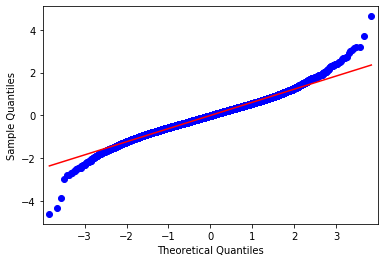

The mean of the residuals is -1.585e-15


In [24]:
# check for the normality of the residuals
sm.qqplot(est.resid, line='s')
pylab.show()

# also check that the mean of the residuals is approx. 0.
mean_residuals = sum(est.resid)/ len(est.resid)
print("The mean of the residuals is {:.4}".format(mean_residuals))

### Model With Price as Target, Quantile-Transformed Data, Updated Parks, and Data narrowed to 1.5 Standard Deviations from the Mean of Price per Square Foot

In [34]:
df = pd.read_csv('./data/all_features_ppsqft_quant.csv', index_col=0)
df.head()

,price,sqft_living,lat,long,price_per_sqft,min_dist_park,closest_distance_to_top_school,closest_distance_to_great_coffee,closest_distance_to_scientology,interaction,...,quant_interaction,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13
0,221900.00,1180,47.51,-122.26,188.05,2.04,0.26,4.39,12.71,3.33,...,-1.11,0,0,1,0,0,0,0,0,0
1,538000.00,2570,47.72,-122.32,209.34,5.67,0.68,14.81,10.80,7.37,...,-0.50,0,0,1,0,0,0,0,0,0
2,180000.00,770,47.74,-122.23,233.77,1.34,2.00,10.63,10.84,21.71,...,0.08,0,1,0,0,0,0,0,0,0
3,604000.00,1960,47.52,-122.39,308.16,2.45,1.73,14.48,11.55,19.97,...,0.05,0,0,1,0,0,0,0,0,0
4,510000.00,1680,47.62,-122.05,303.57,3.72,1.18,8.55,21.18,24.98,...,0.16,0,0,0,1,0,0,0,0,0


In [48]:
features = ['quant_sqft_living','quant_coffee', 'quant_parks', 'quant_schools', 'quant_scientology', 'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10', 'grade_11', 'grade_12', 'grade_13', 'quant_interaction']
target = ['quant_price']
X = df[features]
y = df[target]

# running an iteration of the model using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)

lm10 = LinearRegression().fit(X_train, y_train)
lm10_preds = lm10.predict(X_test)

print('R^2: ', r2_score(y_test, lm10_preds))

R^2:  0.7559870492262424


In [39]:
formula = "quant_price ~ quant_sqft_living+quant_coffee+quant_parks+quant_schools+quant_scientology+quant_interaction+grade_5+grade_6+grade_7+grade_8+grade_9+grade_10+grade_11+grade_12+grade_13"
model = ols(formula= formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            quant_price   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     3711.
Date:                Sun, 29 Nov 2020   Prob (F-statistic):               0.00
Time:                        12:50:45   Log-Likelihood:                -12314.
No. Observations:               17495   AIC:                         2.466e+04
Df Residuals:                   17479   BIC:                         2.479e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.7602      0.123     -6.167      0.000      -1.002      -0.519
quant_sqft_living     0.4987      0.006     89.561      0.000       0.488       0.510
quant_coffee         -0.0269      0.004     -6.792      0.000      -0.035      -0.019
quant_parks          -0.0059      0.004     -1.595      0.111      -0.013       0.001
quant_schools        -0.0690      0.021     -3.229      0.001      -0.111      -0.027
quant_scientology    -0.1565      0.014    -11.053      0.000      -0.184      -0.129
quant_interaction    -0.2132      0.031     -6.879      0.000      -0.274      -0.152
grade_5               0.1626      0.128      1.274      0.203      -0.088       0.413
grade_6               0.3070      0.123      2.492      0.013       0.066       0.549
grade_7               0.5833      0.123      4.736      0.000       0.342       0.825
grade_8               0.8820      0.124      7.131      0.000       0.640       1.124
grade_9               1.1951      0.125      9.596      0.000       0.951       1.439
grade_10              1.4316      0.126     11.387      0.000       1.185       1.678
grade_11              1.7193      0.129     13.377      0.000       1.467       1.971
grade_12              2.0848      0.144     14.463      0.000       1.802       2.367
grade_13              2.3285      0.236      9.847      0.000       1.865       2.792
==============================================================================
Omnibus:                      391.796   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              511.788
Skew:                          -0.283   Prob(JB):                    7.35e-112
Kurtosis:                       3.617   Cond. No.                         175.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
y_predict = lm10.predict(X_test)

X2 = sm.add_constant(X)

# create an OLS model
model = sm.OLS(y, X2)

# fit the data
est = model.fit()

/Users/dtunnicliffe/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


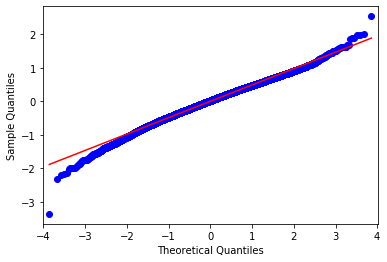

The mean of the residuals is -1.626e-15


In [50]:
# check for the normality of the residuals
sm.qqplot(est.resid, line='s')
pylab.show()

# also check that the mean of the residuals is approx. 0.
mean_residuals = sum(est.resid)/ len(est.resid)
print("The mean of the residuals is {:.4}".format(mean_residuals))

This is our best model, using price as the target, updated park info to reflect only parks and not trail heads/forests, and quantile-transformed variables. 

### Model With Price-Per-Square-Foot as the Target, Updated Parks, and Non-Transformed Data Narrowed to 1.5 Standard Deviations from the Mean of Price per Square Foot

In [43]:
features = ['sqft_living','closest_distance_to_great_coffee', 'min_dist_park', 'closest_distance_to_top_school', 'closest_distance_to_scientology', 'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10', 'grade_11', 'grade_12', 'grade_13', 'interaction']
target = ['price_per_sqft']
X = df[features]
y = df[target]

# running an iteration of the model using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)

lm11 = LinearRegression().fit(X_train, y_train)
lm11_preds = lm11.predict(X_test)

print('R^2: ', r2_score(y_test, lm11_preds))

R^2:  0.4830012860490641


In [45]:
formula = "price_per_sqft ~ sqft_living+closest_distance_to_great_coffee+min_dist_park+closest_distance_to_top_school+closest_distance_to_scientology+grade_5+grade_6+grade_7+grade_8+grade_9+grade_10+grade_11+grade_12+grade_13+interaction"
model = ols(formula= formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         price_per_sqft   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     1113.
Date:                Sun, 29 Nov 2020   Prob (F-statistic):               0.00
Time:                        13:05:25   Log-Likelihood:                -95226.
No. Observations:               17495   AIC:                         1.905e+05
Df Residuals:                   17479   BIC:                         1.906e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                          367.5701     14.084     26.098      0.000     339.964     395.176
sqft_living                         -0.0417      0.001    -54.224      0.000      -0.043      -0.040
closest_distance_to_great_coffee     0.0885      0.088      1.004      0.315      -0.084       0.261
min_dist_park                        0.1045      0.133      0.783      0.433      -0.157       0.366
closest_distance_to_top_school     -13.9363      0.288    -48.447      0.000     -14.500     -13.372
closest_distance_to_scientology     -3.2905      0.054    -61.338      0.000      -3.396      -3.185
grade_5                             -9.4841     14.581     -0.650      0.515     -38.065      19.097
grade_6                              0.0553     14.062      0.004      0.997     -27.508      27.618
grade_7                             18.7652     14.027      1.338      0.181      -8.730      46.260
grade_8                             47.7749     14.063      3.397      0.001      20.211      75.339
grade_9                             85.7026     14.149      6.057      0.000      57.970     113.435
grade_10                           120.0532     14.292      8.400      0.000      92.039     148.067
grade_11                           172.1456     14.661     11.742      0.000     143.409     200.882
grade_12                           242.8476     16.526     14.695      0.000     210.455     275.240
grade_13                           335.8525     27.225     12.336      0.000     282.488     389.217
interaction                          0.2797      0.008     36.375      0.000       0.265       0.295
==============================================================================
Omnibus:                      173.721   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              190.728
Skew:                           0.209   Prob(JB):                     3.84e-42
Kurtosis:                       3.294   Cond. No.                     2.40e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.4e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model With Price-Per-Square-Foot as the Target, Updated Parks, and Quantile-Transformed Data Narrowed to 1.5 Standard Deviations from the Mean of Price per Square Foot

In [47]:
features = ['quant_sqft_living','quant_coffee', 'quant_parks', 'quant_schools', 'quant_scientology', 'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10', 'grade_11', 'grade_12', 'grade_13', 'quant_interaction']
target = ['price_per_sqft']
X = df[features]
y = df[target]

# running an iteration of the model using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)

lm12 = LinearRegression().fit(X_train, y_train)
lm12_preds = lm12.predict(X_test)

print('R^2: ', r2_score(y_test, lm12_preds))

R^2:  0.488518050129346


In [46]:
formula = "quant_price_per_sqft ~ quant_sqft_living+quant_coffee+quant_parks+quant_schools+quant_scientology+quant_interaction+grade_5+grade_6+grade_7+grade_8+grade_9+grade_10+grade_11+grade_12+grade_13"
model = ols(formula= formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     quant_price_per_sqft   R-squared:                       0.489
Model:                              OLS   Adj. R-squared:                  0.488
Method:                   Least Squares   F-statistic:                     1114.
Date:                  Sun, 29 Nov 2020   Prob (F-statistic):               0.00
Time:                          13:06:44   Log-Likelihood:                -18969.
No. Observations:                 17495   AIC:                         3.797e+04
Df Residuals:                     17479   BIC:                         3.809e+04
Df Model:                            15                                         
Covariance Type:              nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.1195      0.180     -6.209      0.000      -1.473      -0.766
quant_sqft_living    -0.4868      0.008    -59.767      0.000      -0.503      -0.471
quant_coffee         -0.0375      0.006     -6.467      0.000      -0.049      -0.026
quant_parks          -0.0067      0.005     -1.240      0.215      -0.017       0.004
quant_schools         0.0159      0.031      0.510      0.610      -0.045       0.077
quant_scientology    -0.1830      0.021     -8.836      0.000      -0.224      -0.142
quant_interaction    -0.4399      0.045     -9.702      0.000      -0.529      -0.351
grade_5               0.3020      0.187      1.618      0.106      -0.064       0.668
grade_6               0.4920      0.180      2.730      0.006       0.139       0.845
grade_7               0.8517      0.180      4.727      0.000       0.498       1.205
grade_8               1.2726      0.181      7.034      0.000       0.918       1.627
grade_9               1.7642      0.182      9.684      0.000       1.407       2.121
grade_10              2.1652      0.184     11.774      0.000       1.805       2.526
grade_11              2.6483      0.188     14.086      0.000       2.280       3.017
grade_12              3.2699      0.211     15.508      0.000       2.857       3.683
grade_13              3.7032      0.346     10.706      0.000       3.025       4.381
==============================================================================
Omnibus:                      343.661   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              741.430
Skew:                           0.009   Prob(JB):                    1.00e-161
Kurtosis:                       4.008   Cond. No.                         175.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""